In [1]:
!git clone https://github.com/riya21parikh/CarInBikeLane.git

Cloning into 'CarInBikeLane'...
remote: Enumerating objects: 4184, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4184 (delta 0), reused 0 (delta 0), pack-reused 4181 (from 2)
Receiving objects: 100% (4184/4184), 846.04 MiB | 49.72 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (4382/4382), done.


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time
import PIL
from tqdm import tqdm
import pandas as pd
import re

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data pre-processing

## Loading and concatenating + removing duplicates/corrupted images

In [4]:
root = "/content/CarInBikeLane/Method1/data/data"
root2 = "/content/CarInBikeLane/Method1/data/data2"
root3 = "/content/CarInBikeLane/Method2/Bikelanes"

# Load all data
blocked2 = os.path.join(root, "blocked2")
blocked3 = os.path.join(root2, "blocked3")

notblocked2 = os.path.join(root, "notblocked2")
notblocked3 = os.path.join(root2, "notblocked3")

blocked = os.path.join(root3, "blocked")
notblocked = os.path.join(root3, "notblocked")

# concatenate them
blocked_folders = [
    os.path.join(root, "blocked2"),
    os.path.join(root2, "blocked3"),
    os.path.join(root3, "blocked"),
]

notblocked_folders = [
    os.path.join(root, "notblocked2"),
    os.path.join(root2, "notblocked3"),
    os.path.join(root3, "notblocked"),
]

blocked_files = []
notblocked_files = []

for folder in blocked_folders:
    blocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

for folder in notblocked_folders:
    notblocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

print("Total blocked images: ", len(blocked_files))
print("Total unblocked images: ", len(notblocked_files))

Total blocked images:  2351
Total unblocked images:  1831


In [5]:
def remove_duplicates(file_list):
    seen = set()
    unique = []
    for f in file_list:
        name = os.path.basename(f)
        if name not in seen:
            seen.add(name)
            unique.append(f)
    return unique

def corrupted(path):
    try:
        img = PIL.Image.open(path)
        img.verify()
        return False
    except:
        return True

In [6]:
blocked_files = remove_duplicates(blocked_files)
notblocked_files = remove_duplicates(notblocked_files)

print("Total blocked images (no duplicates): ", len(blocked_files))
print("Total unblocked images (no duplicates): ", len(notblocked_files))

bad = []

for f in tqdm(blocked_files + notblocked_files):
    if corrupted(f):
        bad.append(f)

print("\n")
print("corrupted files:", len(bad))

Total blocked images (no duplicates):  2231
Total unblocked images (no duplicates):  1721


100%|██████████| 3952/3952 [00:01<00:00, 2059.52it/s]



corrupted files: 0


## Images as Arrays of RGB (if needed)

In [7]:
images = []
labels = []

print("Loading blocked images")
for img_path in blocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(1)

print("Loading notblocked images")
for img_path in notblocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(0)

X = np.array(images)
y = np.array(labels)

X = X / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

Loading blocked images
Loading notblocked images
Train: (2766, 224, 224, 3)
Val: (593, 224, 224, 3)
Test: (593, 224, 224, 3)


# EDA

## Classes check

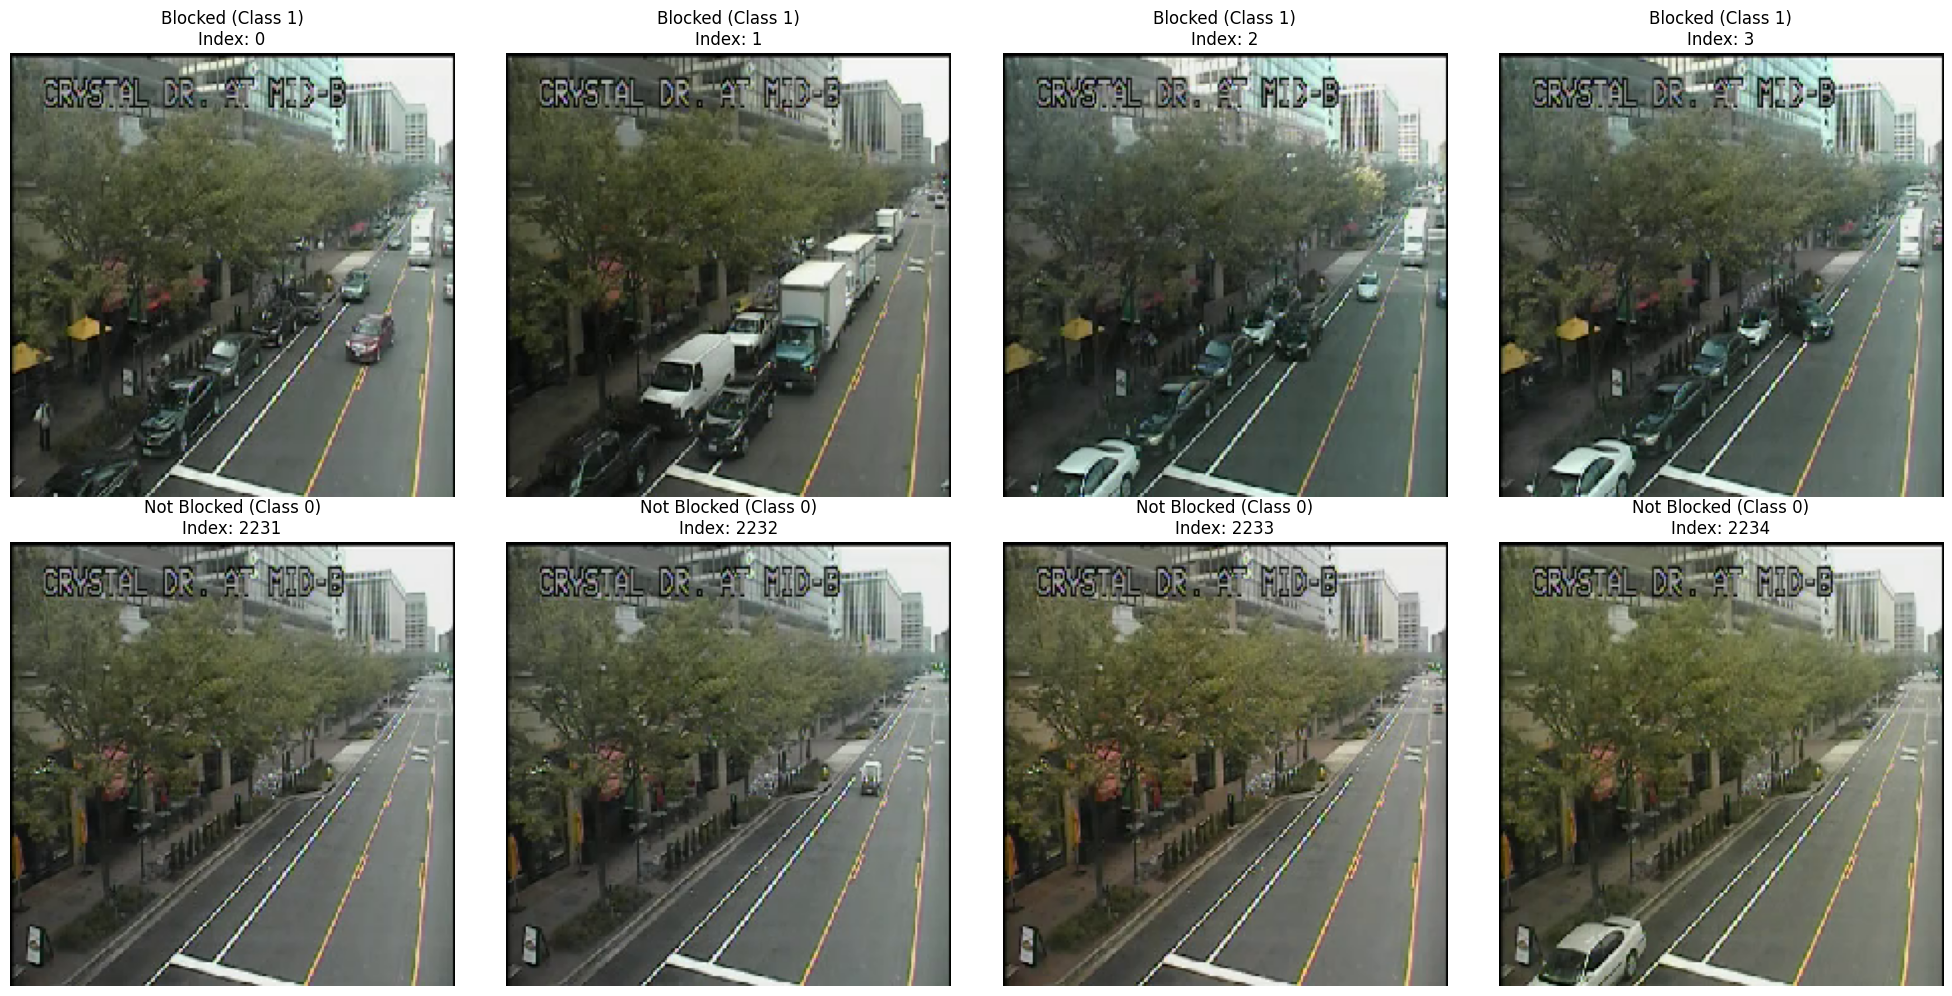

In [8]:
def plot_sample_images(labels, images, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    labels1 = np.array(labels)
    # Get indices for each class
    blocked_indices = np.where(labels1 == 1)[0]
    not_blocked_indices = np.where(labels1 == 0)[0]

    # Plot blocked images
    for i in range(4):
        if i < len(blocked_indices):
            idx = blocked_indices[i]
            img = images[idx]
            display_img = img.astype(np.uint8)
            axes[i].imshow(display_img)
            axes[i].set_title(f'Blocked (Class 1)\nIndex: {idx}')
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    # Plot not blocked images
    for i in range(4):
        if i < len(not_blocked_indices):
            idx = not_blocked_indices[i]
            img = images[idx]
            display_img = img.astype(np.uint8)
            axes[i+4].imshow(display_img)
            axes[i+4].set_title(f'Not Blocked (Class 0)\nIndex: {idx}')
            axes[i+4].axis('off')
        else:
            axes[i+4].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(labels, images)

## Class Balance

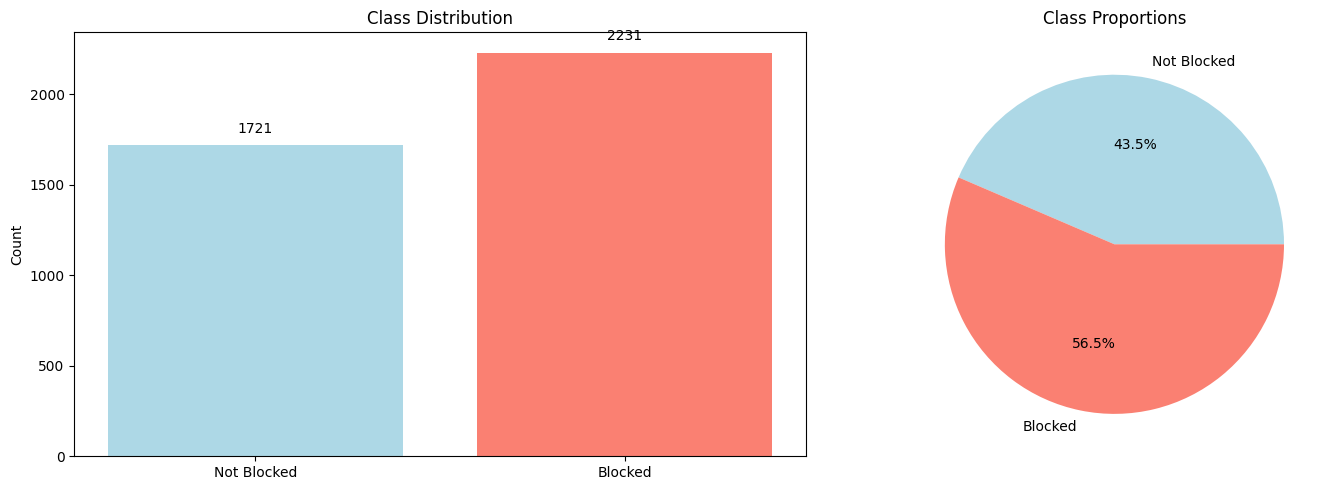

Class balance: 3952 total images
Not blocked: 1721 (43.5%)
Blocked: 2231 (56.5%)


In [12]:
def plot_class_distribution(labels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # force correct semantic labels
    label_counts = pd.Series(labels).value_counts()

    not_blocked = label_counts.get(0, 0)
    blocked = label_counts.get(1, 0)

    # correct order for charts
    counts = [not_blocked, blocked]
    names  = ["Not Blocked", "Blocked"]

    # Count bar chart
    ax1.bar(names, counts, color=['lightblue', 'salmon'])
    ax1.set_title('Class Distribution')
    ax1.set_ylabel('Count')

    for i, v in enumerate(counts):
        ax1.text(i, v + 50, str(v), ha='center', va='bottom')

    # Pie chart
    ax2.pie(counts, labels=names, autopct='%1.1f%%',
            colors=['lightblue', 'salmon'])
    ax2.set_title('Class Proportions')

    plt.tight_layout()
    plt.show()

    print(f"Class balance: {sum(counts)} total images")
    print(f"Not blocked: {not_blocked} ({not_blocked/len(labels)*100:.1f}%)")
    print(f"Blocked: {blocked} ({blocked/len(labels)*100:.1f}%)")

plot_class_distribution(labels)

## Class Balance by split

=== Train ===
Total: 2766
Not Blocked: 1205 (43.6%)
Blocked: 1561 (56.4%)

=== Validation ===
Total: 593
Not Blocked: 258 (43.5%)
Blocked: 335 (56.5%)

=== Test ===
Total: 593
Not Blocked: 258 (43.5%)
Blocked: 335 (56.5%)



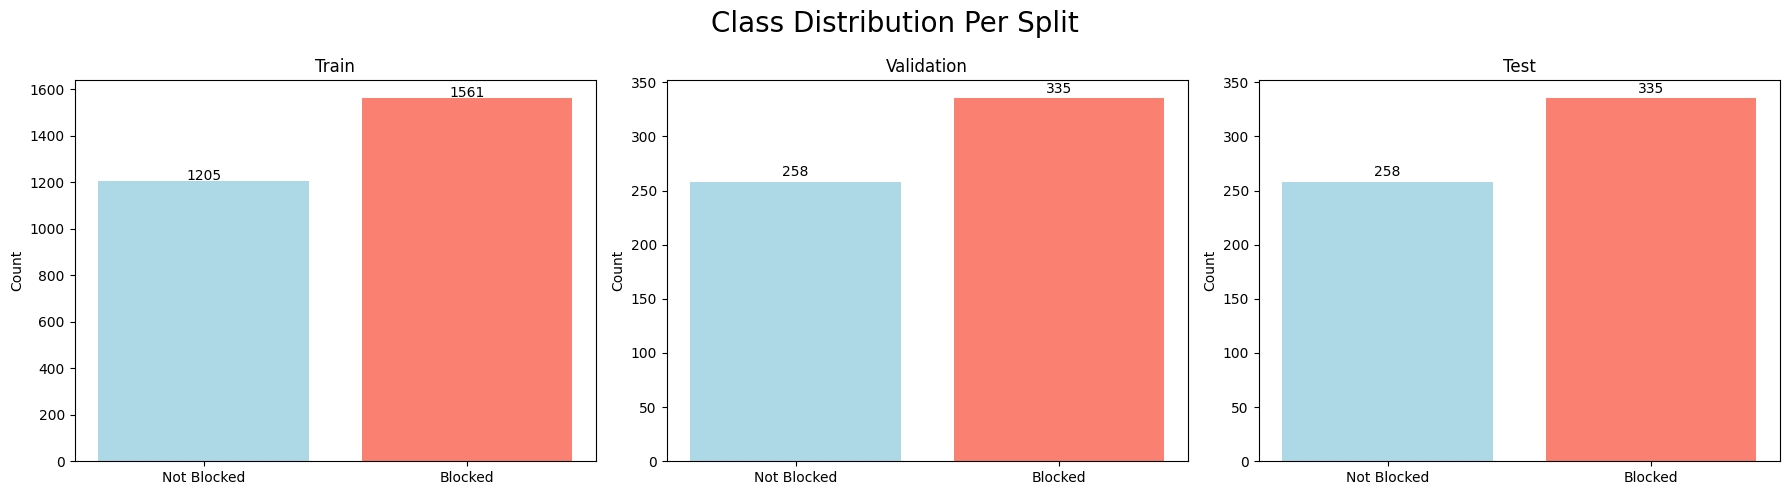

In [13]:
def plot_split_distribution(y_train, y_val, y_test):

    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    fig.suptitle("Class Distribution Per Split", fontsize=20)

    sets = [('Train', y_train), ('Validation', y_val), ('Test', y_test)]

    for ax, (name, labels) in zip(axes, sets):
        counts = pd.Series(labels).value_counts().sort_index()

        ax.bar(['Not Blocked', 'Blocked'], counts.values, color=['lightblue','salmon'])
        ax.set_title(name)
        ax.set_ylabel('Count')

        # counts on top
        for i, v in enumerate(counts.values):
            ax.text(i, v + 5, str(v), ha='center')

        print(f"=== {name} ===")
        print(f"Total: {len(labels)}")
        print(f"Not Blocked: {counts[0]} ({counts[0]/len(labels)*100:.1f}%)")
        print(f"Blocked: {counts[1]} ({counts[1]/len(labels)*100:.1f}%)")
        print()

    plt.tight_layout()
    plt.show()
plot_split_distribution(y_train, y_val, y_test)

## Camera Image Balance

['cam135', 'cam182', 'cam31', 'cam68']
Unique blocked cameras: 4
['cam135', 'cam31', 'cam182', 'cam68']
Unique blocked cameras: 4


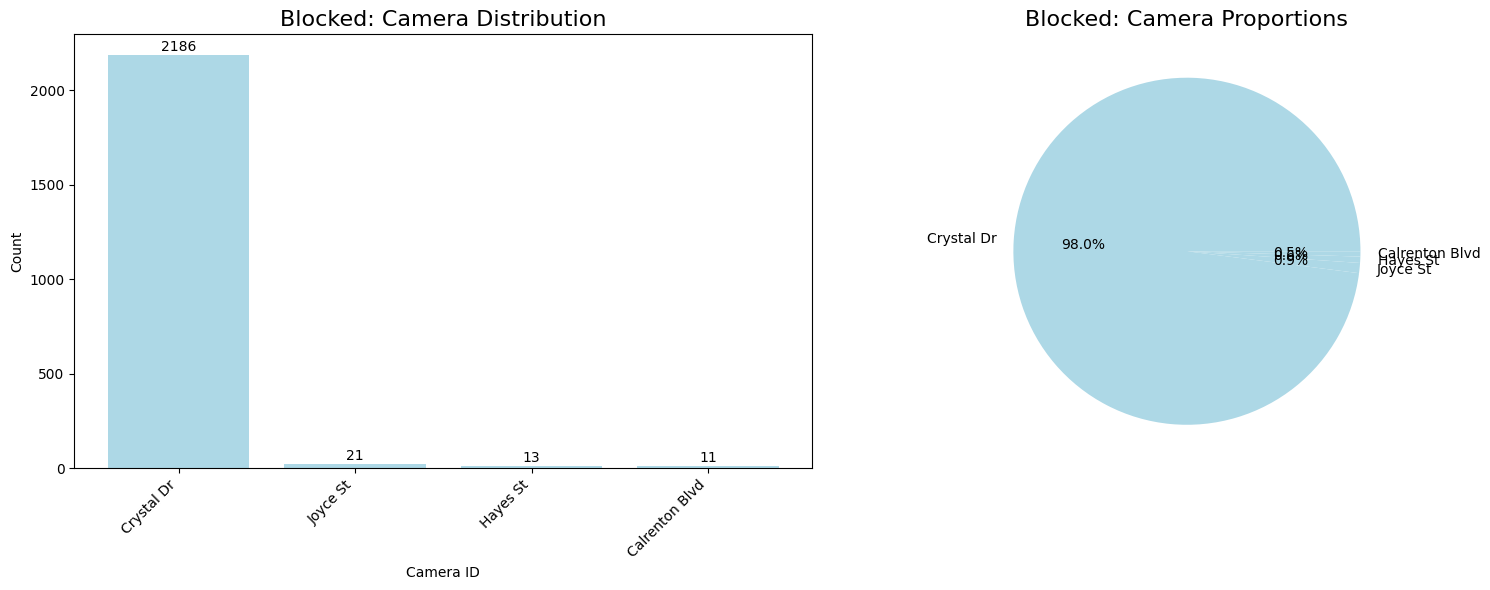

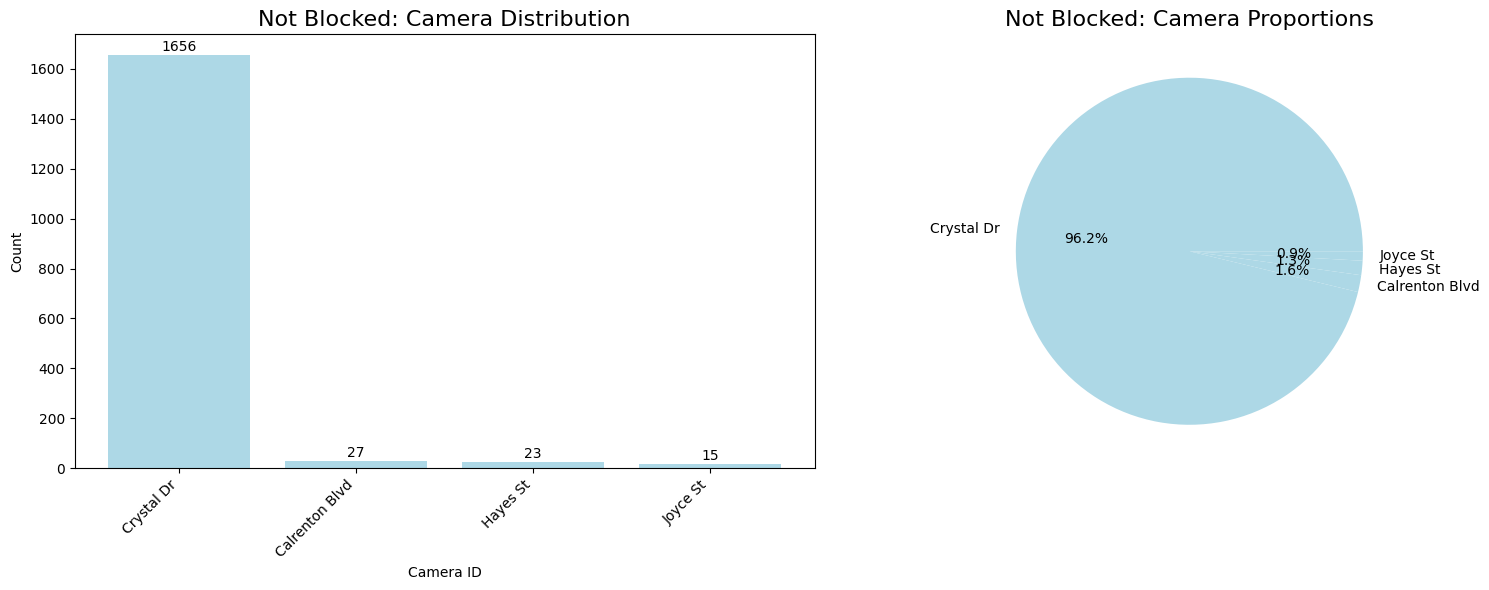

In [15]:
def extract_camera(path_string):
    # matches things like cam123, cam087, cam7, etc
    m = re.search(r"cam\d+", path_string.lower())
    return m.group(0) if m else "unknown"

unique_blocked_cameras = []
for filename in blocked_files:
  cam = extract_camera(filename)
  if cam not in unique_blocked_cameras:
        unique_blocked_cameras.append(cam)

print(unique_blocked_cameras)
print("Unique blocked cameras:", len(unique_blocked_cameras))

unique_notblocked_cameras = []
for filename in notblocked_files:
  cam = extract_camera(filename)
  if cam not in unique_notblocked_cameras:
        unique_notblocked_cameras.append(cam)

print(unique_notblocked_cameras)
print("Unique blocked cameras:", len(unique_notblocked_cameras))

camera_name_map = {
    "cam135": "Crystal Dr",
    "cam182": "Joyce St",
    "cam31": "Hayes St",
    "cam68": "Calrenton Blvd",
    "unknown": "Unknown Camera"
}

blocked_cams = [extract_camera(f) for f in blocked_files]
notblocked_cams = [extract_camera(f) for f in notblocked_files]

named_blocked_cams = [camera_name_map.get(c, c) for c in blocked_cams]
named_notblocked_cams = [camera_name_map.get(c, c) for c in notblocked_cams]

def plot_camera_distribution(camera_list, title_prefix="Blocked"):

    counts = pd.Series(camera_list).value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

    ax1.bar(range(len(counts)), counts.values, color=['lightblue'])
    ax1.set_title(f'{title_prefix}: Camera Distribution', fontsize=16)
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Camera ID')

    ax1.set_xticks(range(len(counts)))
    ax1.set_xticklabels(counts.index, rotation=45, ha='right')

    for i, v in enumerate(counts.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')

    ax2.pie(counts.values, labels=counts.index,
            autopct='%1.1f%%',
            colors=['lightblue'])
    ax2.set_title(f'{title_prefix}: Camera Proportions', fontsize=16)

    plt.tight_layout()
    plt.show()

plot_camera_distribution(named_blocked_cams, title_prefix="Blocked")
plot_camera_distribution(named_notblocked_cams, title_prefix="Not Blocked")

## Balance by Time of Day

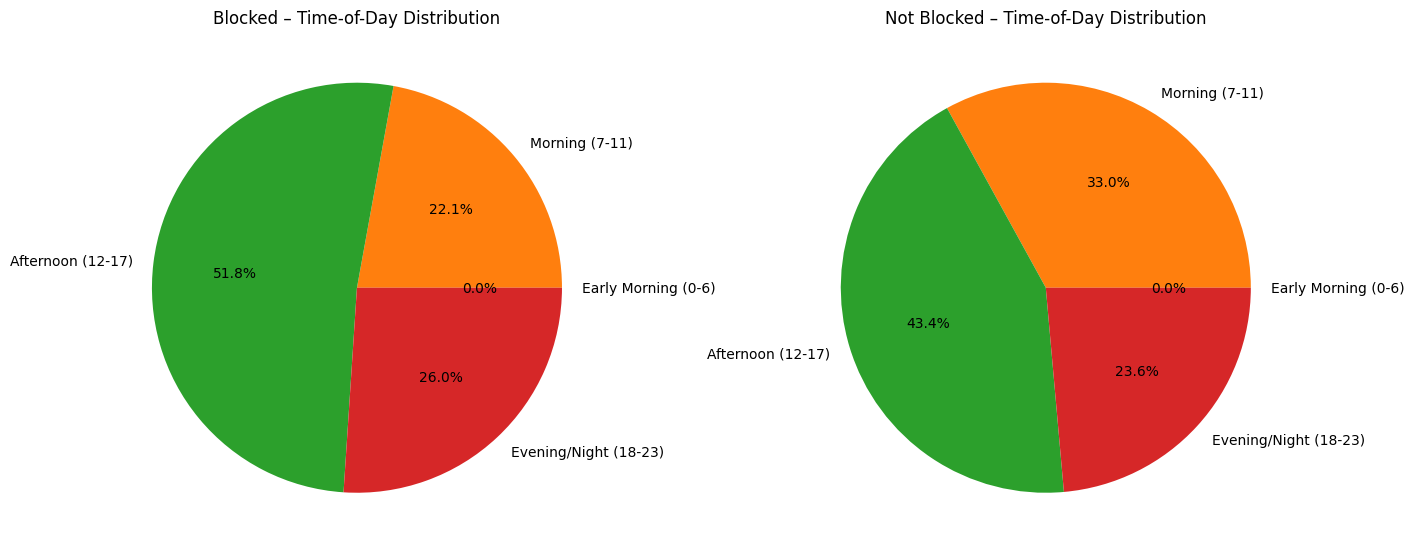

In [16]:
import os
import matplotlib.pyplot as plt

# ---------------------------
# 1. hour extractor
# ---------------------------
def get_hour(path):
    name = os.path.basename(path)
    hour = int(name.split()[1][:2])
    return hour


# ---------------------------
# 2. bucket function
# ---------------------------
def hour_bucket(hour):
    if 0 <= hour < 7:
        return "Early Morning (0-6)"
    elif 7 <= hour < 12:
        return "Morning (7-11)"
    elif 12 <= hour < 18:
        return "Afternoon (12-17)"
    else:
        return "Evening/Night (18-23)"


# ---------------------------
# 3. count hours per bucket
# ---------------------------
def bucket_counts(files):
    counts = {
        "Early Morning (0-6)": 0,
        "Morning (7-11)": 0,
        "Afternoon (12-17)": 0,
        "Evening/Night (18-23)": 0
    }

    for f in files:
        h = get_hour(f)
        b = hour_bucket(h)
        counts[b] += 1

    return counts


blocked_counts     = bucket_counts(blocked_files)
notblocked_counts  = bucket_counts(notblocked_files)


# ---------------------------
# 4. pie chart
# ---------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.pie(blocked_counts.values(),
        labels=blocked_counts.keys(),
        autopct='%1.1f%%')
ax1.set_title("Blocked – Time-of-Day Distribution")

ax2.pie(notblocked_counts.values(),
        labels=notblocked_counts.keys(),
        autopct='%1.1f%%')
ax2.set_title("Not Blocked – Time-of-Day Distribution")

plt.tight_layout()
plt.show()